In [1]:
import pathlib
import numpy as np
import scipy as sp
from matplotlib import pyplot as plt

import SessionTools.two_photon as st2p


%load_ext autoreload
%autoreload 2 

%matplotlib inline

In [2]:
session_info = {'date': "17_06_2024",
                'genotype_dir': 'R18B05LexA_CsChrimsontdT_R60D05Gal4_jGCaMP7f',
                'fly': 'fly3',
                'session': 'alternating_4_7-000',
                'fictrac_scan_num': None,
                'fictrac_dat_file' : None,
                'full_genotype': '+/w-; R18B05LexA/UASjGCaMP7f; R60D05Gal4/LexAOpCsChrimsontdT',
                'ecl date': '6/10/2024',
                'notes': ''}

session_info['fictrac_dir']= f"/media/mplitt/SSD_storage/fictrac_folder/{session_info['genotype_dir']}/{session_info['date']}/{session_info['fly']}"
bruker_folder = pathlib.PurePath('/media/mplitt/SSD_storage/2PData')
# pkl_path = pathlib.PurePath(f"/media/mplitt/SSD_storage/fictrac_folder/{session_info['genotype_dir']}/{session_info['date']}/{session_info['fly']}/fly1_1_scan0.pkl")

pp = st2p.preprocessing.EBImagingSession(session_info = session_info, 
                                         bruker_base_dir = bruker_folder,
                                         fictrac_dir = session_info['fictrac_dir'],
                                         fictrac_dat_file = session_info['fictrac_dat_file'],
                                         fictrac_scan_num = session_info['fictrac_scan_num'])
                                         # fictrac_pkl_path=pkl_path)

In [3]:
pp.extract_metadata()
pp.bruker_to_h5(first_chan=1, overwrite=False)
data_corr, shifts, error, diffphase= pp.motion_correct(pp.data)
pp.align_voltage_recording()


(234, 269)
[########################################] | 100% Completed | 52.19 s


In [4]:
nap = pp.open_napari()

In [5]:
print('')

In [6]:
n_rois = 16
nap.make_phase_masks(n_rois=n_rois)
pp.get_layers(nap)
pp.extract_timeseries(max_proj=False)

In [7]:
y = pp.calculate_zscored_F('rois', exp_detrend=True, zscore=False)
y_sm = sp.ndimage.gaussian_filter1d(sp.ndimage.gaussian_filter1d(y-1, 1, axis=-1),.7,axis=1, mode='wrap')

In [8]:
pp.save()

In [9]:
mp = pp.metadata['mark_points']



stim_on_times = np.zeros((len(mp['custom_laser_power']),))
stim_on_times += mp['initial_delay']+mp['duration']+mp['inter_point_delay']
stim_on_times = np.cumsum(stim_on_times)
stim_off_times = stim_on_times + mp['duration']

time = pp.voltage_recording_aligned['Time(ms)']

stim_mask = np.zeros_like(time)
for on,off in zip(stim_on_times, stim_off_times):
    stim_mask[(time>=on-1)&(time<=off)]=1
stim_mask = stim_mask>0

    

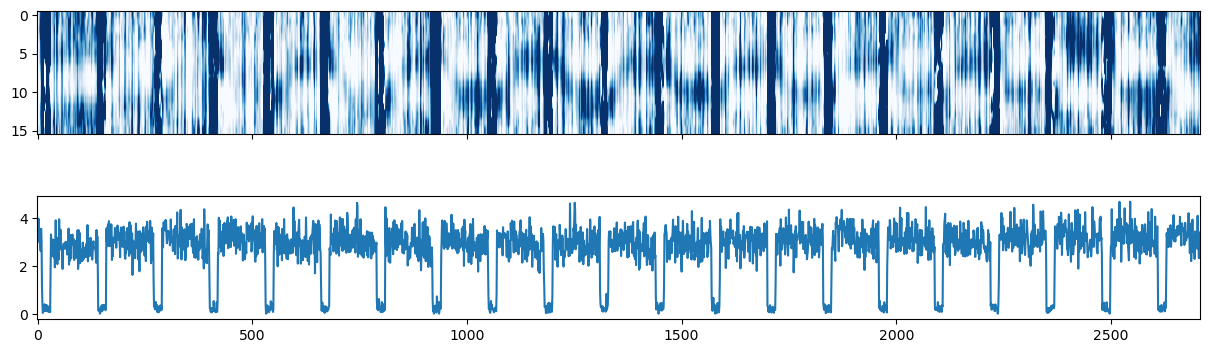

In [12]:
fig, ax= plt.subplots(2,1,figsize=[15,4], sharex=True)
fig.subplots_adjust(hspace=.5)
ax[0].imshow(y_sm[-1,::-1,:], aspect='auto', cmap= 'Blues',vmin=0,vmax=.7) 
ax[1].plot(pp.timeseries['background'][-1,0,:])